# Préambule

## Quelques principes dans la collecte de données

La façon dont on récupère les données (scrapping) implique du bon sens dans la démarche afin d'éviter de surcharger les sites inutilement, ou de se faire considérer comme un robot, ce qui empècherait de collecter des données. Pour cela, on essaye au maximum de ne pas scrapper plusieurs fois des mêmes pages. Ainsi, on étudie à l'avance les variables d'intérêt et on teste à petite échelle si le code fonctionne avant de lancer le scrapping sur un nom de page plus grand.
De plus, on limite le nombre de requête temporel: on lance ainsi une requête tous les au plus 3 secondes. En pratique ce nombre est aléatoire entre 3 et 6 secondes ici pour éviter d'être détecter comme un automate.

## Philosophie du stockage des données

Le point précédent suppose que l'on stocke avec attention les données. On distingue pour cela deux fichiers: original_data.csv et working_data.csv. 
Le premier, original_data.csv, sert à stocker toutes les variables récupérées par scrapping, et ne sert qu'à cela. Il doit donc être sauvegardé fréquemment pour éviter une mauvaise manipulation qui aménerait à perdre les données.
Le second, working_data.csv, est le fichier de travail. Il s'agit initialement d'une copie de l'original, que l'on peut modifier pour obtenir de nouvelles variables d'intérêt, des données plus claires, etc. 

En théorie et idéalement, l'hérédité serait claire: working_data.csv serait "fils" de original_data.csv. En pratique, on peut avoir besoin de certains éléments de working_data.csv pour scrapper de nouveaux sites et rajouter des données à original_data.csv.

L'idée est également d'avoir une structure de données dynamique: on veut pouvoir ajouter des données à notre base, les traiter, puis en rajouter de nouvelles si besoin. Cela suppose que le code permette de rajouter simplement des données, et de faire des opérations (en particulier de scrapping) uniquement sur ces nouvelles données (souvent identifiables par des champs "NaN" dans certaines colonnes).

# Avant tout, quelques imports

On importe les packages de bibliothèques externe dont on a besoin

In [3]:
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

ModuleNotFoundError: No module named 'selenium'

On importe les fonction de auxiliary.py dont on a besoin. Ce sont des fonctions "génériques" qui permettent par exemple de faire certaines opérations sur des dataframes.

In [4]:
from auxiliary_functions import remove_zero_start
from auxiliary_functions import intersect_list
from auxiliary_functions import complement_list
from auxiliary_functions import split_list
from auxiliary_functions import mean_error
from auxiliary_functions import split_data

On importe les fonctions de scrapping dont on a besoin. Celle ci sont stockées dans un fichier Python à part pour éviter de surcharger ce Notebook.

In [26]:
from scrapping_function import add_expansion
from scrapping_function import add_tournament_use
from scrapping_function import add_price_trends

# Première étape de Scrapping: récupération de données de bases

On récupère des données de base sur les cartes de chaque extensions parmis une liste d'extension que l'on choisit.
On utilise pour cela le site de "magic card market", dans la section "Pokémon".
On récupère pour chaque carte d'une extension donnée:
- Le nom
- Le nom d'extension
- La date de sortie d'extension
- Le prix minimum auquel on peut trouver la carte
- Le nombre d'exemplaire en vente actuellement
- La rareté
- L'URL vers la page spécifique à la carte sur MKM, ou plus d'informations sont disponibles

Ces données, insuffisantes pour l'analyse, sont néanmoins le point de départ de recherches plus détaillées: les données de nom de carte (comportant un code d'identification) et de nom d'extension permettent d'aller chercher des informations plus précises facilement.

In [27]:
expansion_list =  ["Lost-Origin", "Stellar-Crown", "Surging-Sparks", "Shrouded-Fable", "Twilight-Masquerade", "Temporal-Forces", "Paldean-Fates", "Paradox-Rift", "151", "Obsidian-Flames", "Paldea-Evolved", "Scarlet-Violet", "Crown-Zenith", "Silver-Tempest", "Astral-Radiance"]

In [28]:
for expansion in expansion_list:
    add_expansion(expansion)

In [29]:
data = pd.read_csv("original_data.csv")
data.loc[pd.isna(data["Index"]), "Index"] = data.index.to_series().astype(int)
data["Index"] = data["Index"].astype(int)

In [30]:
data = pd.read_csv("original_data.csv")
data.tail(10)

,Index,Name,Expansion,Min price,Exemplaires en vente,Rareté,mkm_url,expansion_release_date,Tournament_last_month,Price trend,Price 7 days,Price 30 days
3779,3779,Hisuian Decidueye VSTAR (ASR 084),Astral-Radiance,"2,33 €",180,Oversized,https://www.cardmarket.com/en/Pokemon/Products...,"27TH MAY, 2022",NaN,NaN,NaN,NaN
3780,3780,Darkrai VSTAR (ASR 099),Astral-Radiance,"1,30 €",31,Oversized,https://www.cardmarket.com/en/Pokemon/Products...,"27TH MAY, 2022",NaN,NaN,NaN,NaN
3781,3781,Live Code Card (Build & Battle Kit) (ASR),Astral-Radiance,"0,09 €",419,Online Code Card,https://www.cardmarket.com/en/Pokemon/Products...,"27TH MAY, 2022",NaN,NaN,NaN,NaN
3782,3782,Live Code Card (Toxel Blister) (ASR),Astral-Radiance,"0,02 €",106,Online Code Card,https://www.cardmarket.com/en/Pokemon/Products...,"27TH MAY, 2022",NaN,NaN,NaN,NaN
3783,3783,Hisuian Voltorb (ASR 002),Astral-Radiance,"0,02 €",26,Promo,https://www.cardmarket.com/en/Pokemon/Products...,"27TH MAY, 2022",NaN,NaN,NaN,NaN
3784,3784,Hisuian Growlithe (ASR 070),Astral-Radiance,"0,02 €",26,Promo,https://www.cardmarket.com/en/Pokemon/Products...,"27TH MAY, 2022",NaN,NaN,NaN,NaN
3785,3785,Live Code Card (Eevee Blister) (ASR),Astral-Radiance,"0,02 €",192,Online Code Card,https://www.cardmarket.com/en/Pokemon/Products...,"27TH MAY, 2022",NaN,NaN,NaN,NaN
3786,3786,Hisuian Sneasel (ASR 092),Astral-Radiance,"0,02 €",31,Promo,https://www.cardmarket.com/en/Pokemon/Products...,"27TH MAY, 2022",NaN,NaN,NaN,NaN
3787,3787,Live Code Card (Pokémon Center Elite Trainer B...,Astral-Radiance,"4,00 €",1,Online Code Card,https://www.cardmarket.com/en/Pokemon/Products...,"27TH MAY, 2022",NaN,NaN,NaN,NaN
3788,3788,Roxanne (ASR 150),Astral-Radiance,"0,02 €",1,Promo,https://www.cardmarket.com/en/Pokemon/Products...,"27TH MAY, 2022",NaN,NaN,NaN,NaN


# Première sélection des données: barrière de prix

Le prix minimum des cartes est un bon indicateur nous permettant de faire un premier tri dans nos données. En effet, si notre variable d'intérêt est le prix de vente, il est inutile d'inclure toutes les cartes dont le prix est de 2 centimes, qui est le prix minimum de vente sur MKM: toutes ces cartes sont disponibles en abondance et n'ont pas de "rareté".
On enlève également certaines types de cartes: les cartes "Oversized" et "Online Code Card" qui ne sont pas jouables et ne seront pas étudiées dans notre cas.
On enlève enfin les cartes ayant des valeurs non acquise pour le prix (qui n'existent en réalité pas).

In [31]:
original_data = pd.read_csv("original_data.csv")
original_data.to_csv("working_data.csv", index = False)

data = pd.read_csv("working_data.csv")
data = data[(data["Rareté"] != "Online Code Card") & (data["Rareté"] != "Oversized") & (data["Rareté"] != "Fixed")]
data = data.dropna(subset=["Min price"])

data["Min price"] = (data['Min price'].str[:-5] + data['Min price'].str[-4:-2]).astype(int)/100
data = data[(data["Min price"] >= 0.5)]

# Seconde étape de scrapping: récupération du nombre d'utilisation en tournoi

On récupère sur un autre site (limitlesstcg) le nombre d'utilisation de chaque carte en tournoi dans le dernier mois. 
Cette donnée est un facteur intéressant car les résultats en tournoi d'une carte peuvent inciter les gens à l'acheter, et donc faire varier le prix ou la disponibilité.

A partir de cette étape, on rajoute des données à notre tableau, mais pas nécessairement sur toutes les lignes. En effet, le jeu de donné étant volumineux, on ne peut scrapper individuellement les pages de chaque carte, et on choisit juste des catégories de cartes sur lesquels on veut plus d'information. En particulier, un moyen de sélectionner un ensemble de carte est la rareté.

On a également besoin de rajouter des colonnes dans notre tableau working_data pour scrapper plus facilement.

In [32]:
data[["Name", "Code"]] = data["Name"].str.split(" \(", expand = True)
data ["Code"] = data["Code"].str.rstrip(")")
data[["Expansion_code", "Number_code"]] = data["Code"].str.split(" ", expand = True)
data["Number_code"] = data["Number_code"].apply(remove_zero_start)
data.to_csv("working_data.csv", index = False)

On récupère toutes les lignes qui ont une rareté donnée et pour lesquelles on a pas encore récupéré la donnée du nombre de tournois joués le mois passé.

In [33]:
rarity_list = data["Rareté"].unique().tolist()

In [34]:
indexes = []
for rarity in rarity_list:
    indexes += data.index[(data["Rareté"] == rarity)
                            & (pd.isna(data["Tournament_last_month"]))].to_list()
indexes_list = split_list(indexes, step=15)

In [35]:
for indexes in indexes_list:
    add_tournament_use(indexes)

# Troisième étape de scrapping: on récupère des données plus précises sur les prix

En réalité, le prix minimum des cartes n'est pas un très bon indicateur du prix: cela peut traduire des cartes en mauvais états, ou des destinations mals desservies, résultant en des frais de port plus élevés.
Un meilleurs indicateur est présent sur la page de la carte: il s'agit du "Price Trend" qui est le prix moyen auquel s'échange la carte. En plus de cette variable, on récupère aussi le prix moyen sur les 7 et 30 derniers jours.

In [36]:
indexes = []
for rarity in rarity_list:
    indexes += data.index[(data["Rareté"] == rarity)
                            & (pd.isna(data["Price trend"]))].to_list()
indexes_list = split_list(indexes, step=15)

In [37]:
for indexes in indexes_list:
    add_price_trends(indexes)

# Etat des lieux des données et mise en forme

In [38]:
original_data = pd.read_csv("original_data.csv")
original_data.to_csv("working_data.csv", index = False)
data = pd.read_csv("working_data.csv")


data = data[(data["Rareté"] != "Online Code Card") & (data["Rareté"] != "Oversized") & (data["Rareté"] != "Fixed")]
data = data.dropna(subset=["Min price"])
data["Min price"] = (data['Min price'].str[:-5] + data['Min price'].str[-4:-2]).astype(int)/100
data = data[(data["Min price"] >= 0.5)]


data[["Name", "Code"]] = data["Name"].str.split(" \(", expand = True)




sub_data = data.dropna().copy()

sub_data["Price trend"] = (sub_data["Price trend"].str[:-5] + sub_data["Price trend"].str[-4:-2]).astype(int)/100
sub_data["Price 7 days"] = (sub_data["Price 7 days"].str[:-5] + sub_data["Price 7 days"].str[-4:-2]).astype(int)/100
sub_data["Price 30 days"] = (sub_data["Price 30 days"].str[:-5] + sub_data["Price 30 days"].str[-4:-2]).astype(int)/100
order = ["Index", "Name", "Expansion", "Rareté", "Min price", "Price trend", "Price 7 days", "Price 30 days", "Tournament_last_month"]
sub_data = sub_data[order]

In [39]:
len(sub_data)

1114

In [40]:
sub_data.head(5)

,Index,Name,Expansion,Rareté,Min price,Price trend,Price 7 days,Price 30 days,Tournament_last_month
2,2,Rotom V,Lost-Origin,Ultra Rare,0.70,3.69,3.56,3.23,193.0
13,13,Hisuian Arcanine,Lost-Origin,Illustration Rare,0.50,1.31,1.34,1.24,0.0
16,16,Giratina VSTAR,Lost-Origin,Ultra Rare,2.00,3.20,3.33,3.29,131.0
17,17,Gengar,Lost-Origin,Illustration Rare,3.10,5.05,5.11,4.43,0.0
20,20,Charizard,Lost-Origin,Illustration Rare,4.95,7.23,6.90,6.63,0.0


# Statistiques descriptives sur les données

On veut pouvoir comprendre (humainement) mieux nos données. On réalise pour cela des statistiques descriptives.
Dans ce but, on va construire des graphes affichant le nombre de cartes répondant à certaines catégorie (extension, rareté).
On pourra aussi regarder le prix moyen de vente dans chaque extension.

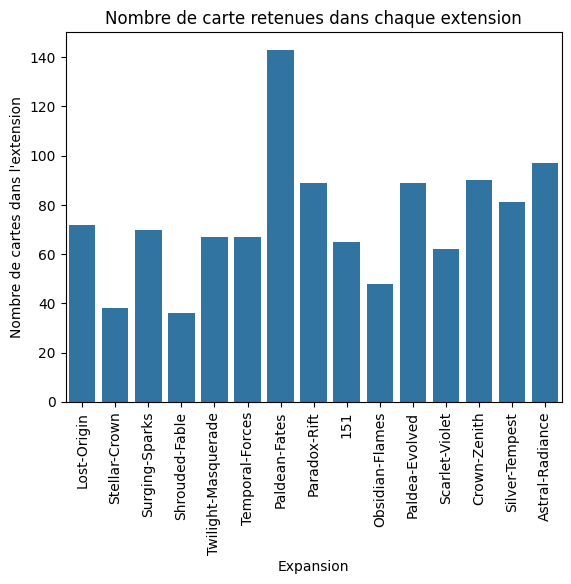

In [41]:
sns.countplot(data = sub_data, x = "Expansion")
plt.title("Nombre de carte retenues dans chaque extension")
plt.xticks(rotation=90)
plt.ylabel("Nombre de cartes dans l'extension")

plt.show()

[]

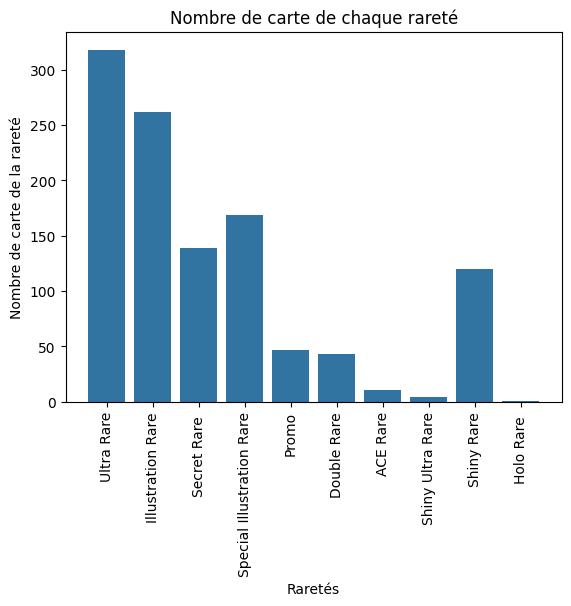

In [42]:
sns.countplot(data = sub_data, x = "Rareté")
plt.xlabel("Raretés")
plt.ylabel("Nombre de carte de la rareté")
plt.title("Nombre de carte de chaque rareté")
plt.xticks(rotation=90)

plt.plot()

# Analyse des données

On analyse les données traitées auparavant par deux méthodes: une régression linéaire et un réseau de neurone.
Notre but est ici de prédire la variable "Price trend" à partir des autres variables. On utilise donc pour cela 80% des données pour l'apprentissage, et on test notre prédiction sur les 20% des données restantes.
Notre "erreur" de prédiction sera la moyenne sur l'ensemble de l'échantillon test des erreurs entre la valeur prédite et la valeur réelle de la variable "Price trend".

## Première analyse sur les données

On fait une première étape d'analyse ou on va juste chercher à faire une régression du prix en fonction des différentes données.
On pourrait pour cela récupérer directement utiliser des modules déjà codé, mais on préfère ici coder une fonction de zéro.
Celle ci prend en attribut un tableau de donné, une liste des nom de colonne du tableau servant d'élément explicatifs, le nom de la colonne souhaitant être expliquée, et renvoie la liste des coéfficients des variables explicatives dans la régression.
Les fonction "d'économétrie" seront dans le fichier regression_function.py.

In [43]:
from regression_function import *

In [44]:
sub_data = sub_data[(sub_data["Price 30 days"] <= 30)]

In [45]:
for rarity in rarity_list:
    sub_data[rarity] = (sub_data["Rareté"] == rarity).astype(int)
for expansion in expansion_list:
    sub_data[expansion] = (sub_data["Expansion"] == expansion).astype(int)
explicative_variables = ["Price 30 days", "Price 7 days"] + ["Tournament_last_month"] + rarity_list[:-1] + expansion_list[:-1]

In [2]:
learning_data, testing_data = split_data(data, 0.8)

NameError: name 'split_data' is not defined

In [120]:
beta, R2, R2_adj = mse_regression(learning_data, explicative_variables, "Price trend")
regression = sub_data.pop("Regression")
sub_data.insert(6, 'Regression', regression) 

LinAlgError: Singular matrix

In [ ]:
###
testing_data["Prediction: regression"] = testing_data.apply(lambda row: sum([beta[i]*row[explicative_variables[i]] for i in range(len(explicative_variables))]), axis = 1)

In [ ]:
ecart_moyen = mean_error(testing_data, "Price trend", "Prediction: regression")
"""print("R2",R2)
print("R2 ajusté", R2_adj)
print("Beta", beta)
print("Mean_error", ecart_moyen)"""

'print("R2",R2)\nprint("R2 ajusté", R2_adj)\nprint("Beta", beta)\nprint("Mean_error", ecart_moyen)'

In [ ]:
sub_data.head(10)

,Index,Name,Expansion,Rareté,Min price,Price trend,Regression,Price 7 days,Price 30 days,Tournament_last_month,...,Temporal-Forces,Paldean-Fates,Paradox-Rift,151,Obsidian-Flames,Paldea-Evolved,Scarlet-Violet,Crown-Zenith,Silver-Tempest,Astral-Radiance
2,2,Rotom V,Lost-Origin,Ultra Rare,0.70,3.69,3.44,3.56,3.23,193.0,...,0,0,0,0,0,0,0,0,0,0
13,13,Hisuian Arcanine,Lost-Origin,Illustration Rare,0.50,1.31,1.24,1.34,1.24,0.0,...,0,0,0,0,0,0,0,0,0,0
16,16,Giratina VSTAR,Lost-Origin,Ultra Rare,2.00,3.20,3.34,3.33,3.29,131.0,...,0,0,0,0,0,0,0,0,0,0
17,17,Gengar,Lost-Origin,Illustration Rare,3.10,5.05,4.91,5.11,4.43,0.0,...,0,0,0,0,0,0,0,0,0,0
20,20,Charizard,Lost-Origin,Illustration Rare,4.95,7.23,6.92,6.90,6.63,0.0,...,0,0,0,0,0,0,0,0,0,0
22,22,Snorlax,Lost-Origin,Illustration Rare,0.99,1.95,1.97,2.04,1.95,0.0,...,0,0,0,0,0,0,0,0,0,0
24,24,Pikachu,Lost-Origin,Illustration Rare,3.95,5.70,5.91,5.88,5.71,0.0,...,0,0,0,0,0,0,0,0,0,0
49,49,Pikachu VMAX,Lost-Origin,Secret Rare,5.00,7.76,7.62,7.95,7.23,0.0,...,0,0,0,0,0,0,0,0,0,0
54,54,Mew VMAX,Lost-Origin,Secret Rare,4.99,6.74,6.82,6.84,7.00,0.0,...,0,0,0,0,0,0,0,0,0,0
77,77,Eternatus V,Lost-Origin,Special Illustration Rare,2.45,4.53,4.30,4.79,4.21,0.0,...,0,0,0,0,0,0,0,0,0,0


# Une alternative dans l'analyse des données: un réseau de neurones

In [91]:
from neural_network import *

In [92]:
d = {}
l = sub_data["Expansion"].unique()
for i in range(len(l)):
    expansion = l[i]
    d[expansion] = i
sub_data["Expansion number"] = sub_data["Expansion"].map(d)

d = {}
l = sub_data["Rareté"].unique()
for i in range(len(l)):
    rarity = l[i]
    d[rarity] = i
sub_data["Rareté number"] = sub_data["Rareté"].map(d)

In [ ]:
learning_data, testing_data = split_data(data, 0,8)

In [94]:
column_titles_list = ["Price 30 days", "Price 7 days"] + ["Tournament_last_month"] + ["Rareté number"] + ["Expansion number"]
output_column = ["Price trend"]

size_list = [len(column_titles_list), 100, len(output_column)]
function_list = []
for i in range(len(size_list)-1):
    function_list.append(Sigmoid())


path = "neural_network"
create_network_path = path + "/original_network"
working_network_path = path + "/working_network"
saved_network_path = path + "/saved_network"
i = 1

create_new_network(path = create_network_path, loss_function = Distance(), size_list = size_list , function_list = function_list, column_titles_list= column_titles_list, output_column= output_column)
copy_network(create_network_path, working_network_path)
#copy_network(create_network_path, saved_network_path + str(i))

In [95]:
#train_network(working_network_path, learning_data, n_epoch= 10, learning_factor= 0.003)
#train_network_score(working_network_path, learning_data, score = 3, n_max= 30, learning_factor= 0.0005)

In [96]:
apply_network(working_network_path, testing_data)
neural_prediction = testing_data.pop("Neural prediction")
testing_data.insert(6, 'Neural prediction', neural_prediction) 

testing_data["Neural prediction"] = testing_data.apply(lambda row: max(row["Neural prediction"], 0), axis = 1)

print(mean_error(sub_data, "Prediction: regression", "Price trend"))
print(mean_error(sub_data, "Neural prediction", "Price trend"))
sub_data.head(15)

0.45674778761061946
6.592994799610859


,Index,Name,Expansion,Rareté,Min price,Price trend,Neural prediction,Regression,Price 7 days,Price 30 days,...,Paradox-Rift,151,Obsidian-Flames,Paldea-Evolved,Scarlet-Violet,Crown-Zenith,Silver-Tempest,Astral-Radiance,Expansion number,Rareté number
2,2,Rotom V,Lost-Origin,Ultra Rare,0.70,3.69,0.000000,3.44,3.56,3.23,...,0,0,0,0,0,0,0,0,0,0
13,13,Hisuian Arcanine,Lost-Origin,Illustration Rare,0.50,1.31,22.868582,1.24,1.34,1.24,...,0,0,0,0,0,0,0,0,0,1
16,16,Giratina VSTAR,Lost-Origin,Ultra Rare,2.00,3.20,0.000000,3.34,3.33,3.29,...,0,0,0,0,0,0,0,0,0,0
17,17,Gengar,Lost-Origin,Illustration Rare,3.10,5.05,10.958974,4.91,5.11,4.43,...,0,0,0,0,0,0,0,0,0,1
20,20,Charizard,Lost-Origin,Illustration Rare,4.95,7.23,8.714264,6.92,6.90,6.63,...,0,0,0,0,0,0,0,0,0,1
22,22,Snorlax,Lost-Origin,Illustration Rare,0.99,1.95,20.455027,1.97,2.04,1.95,...,0,0,0,0,0,0,0,0,0,1
24,24,Pikachu,Lost-Origin,Illustration Rare,3.95,5.70,9.953552,5.91,5.88,5.71,...,0,0,0,0,0,0,0,0,0,1
49,49,Pikachu VMAX,Lost-Origin,Secret Rare,5.00,7.76,13.144453,7.62,7.95,7.23,...,0,0,0,0,0,0,0,0,0,2
54,54,Mew VMAX,Lost-Origin,Secret Rare,4.99,6.74,14.456383,6.82,6.84,7.00,...,0,0,0,0,0,0,0,0,0,2
77,77,Eternatus V,Lost-Origin,Special Illustration Rare,2.45,4.53,26.433061,4.30,4.79,4.21,...,0,0,0,0,0,0,0,0,0,3
